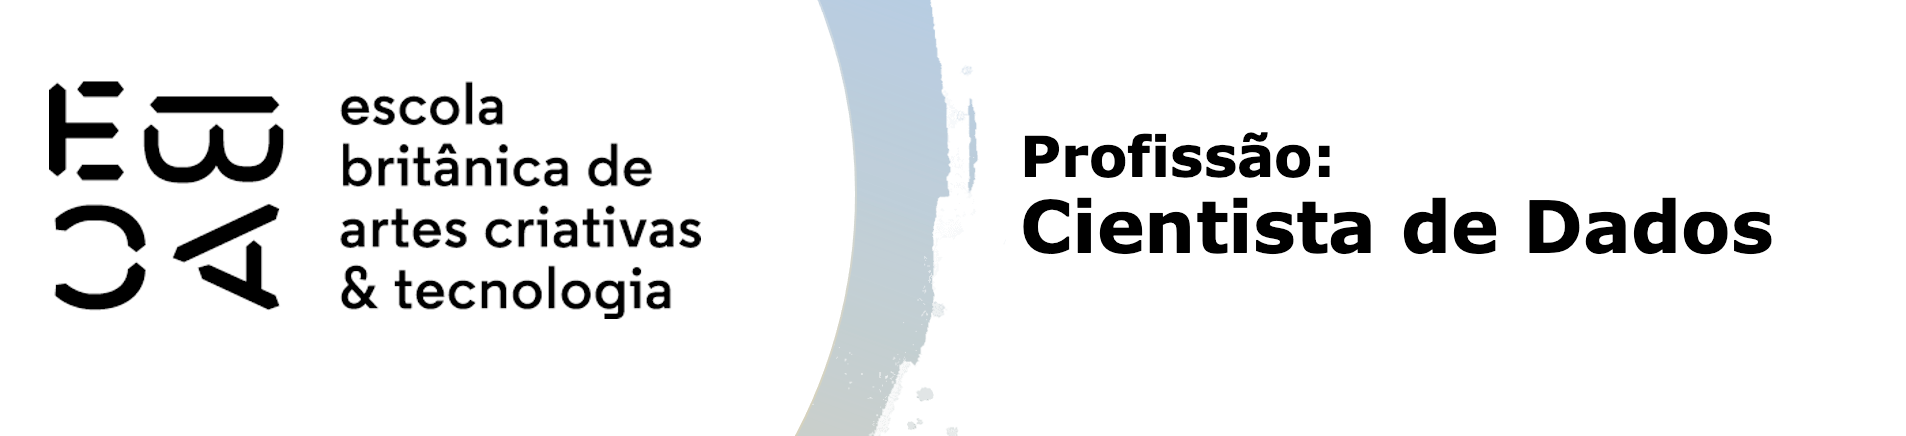

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo de previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [34]:
print("Nulos por coluna antes do tratamento:")
print(df.isna().sum())

df = df.fillna(df.mean(numeric_only=True))

Nulos por coluna antes do tratamento:
data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64


In [35]:

print("Nulos por coluna após o tratamento:")
print(df.isna().sum())

Nulos por coluna após o tratamento:
data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64


In [36]:
# Criando a variável log_renda

df['log_renda'] = np.log(df['renda'])

# Separando os dados em treino e teste, tirando 'data_ref' e 'index'
cols_drop = ['data_ref', 'index']
df_model = df.drop(columns=[c for c in cols_drop if c in df.columns])

df_treino, df_teste = train_test_split(df_model, test_size=0.2,random_state=42,shuffle=True)

In [37]:
formula = """
log_renda ~ idade + tempo_emprego + qt_pessoas_residencia
       + C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel)
       + C(tipo_renda) + C(educacao) + C(estado_civil) + C(tipo_residencia)
"""

modelo = smf.ols(formula=formula, data=df_treino).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 1.691e+04
Date:                Sat, 30 Aug 2025   Prob (F-statistic):               0.00
Time:                        10:00:22   Log-Likelihood:            -8.5139e+05
No. Observations:              600000   AIC:                         1.703e+06
Df Residuals:                  599976   BIC:                         1.703e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [38]:
y_pred = modelo.predict(df_teste)

r2_teste = r2_score(df_teste['log_renda'], y_pred)

print(f"R² ajustado (treino): {modelo.rsquared_adj:.4f}")
print(f"R² (teste):           {r2_teste:.4f}")

R² ajustado (treino): 0.3933
R² (teste):           0.3930


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

### Análise dos Resíduos

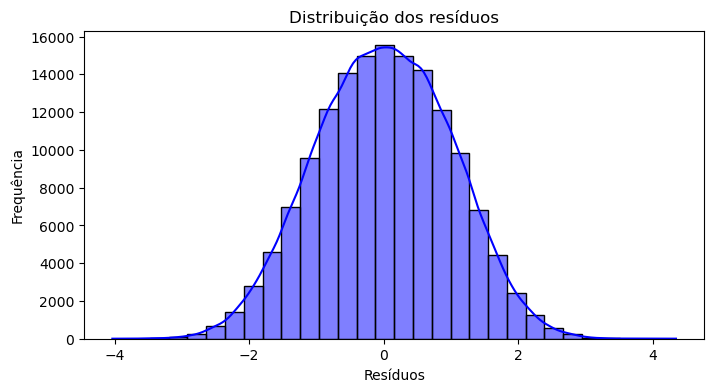

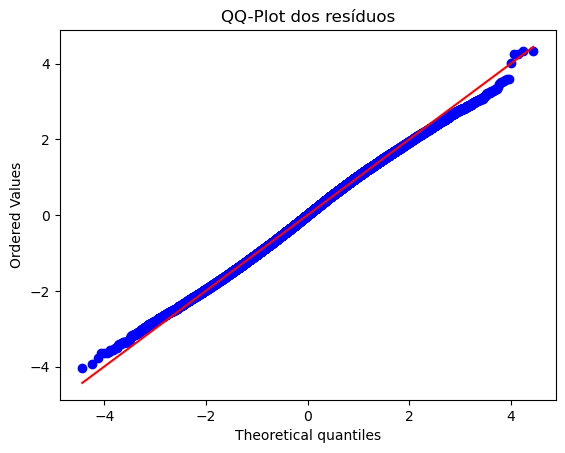

In [39]:
# Análise dos resíduos
residuos = df_teste['log_renda'] - y_pred

# Histograma + curva normal dos resíduos
plt.figure(figsize=(8,4))
sns.histplot(residuos, kde=True, bins=30, color="blue")
plt.title("Distribuição dos resíduos")
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.show()

# QQ-Plot
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("QQ-Plot dos resíduos")
plt.show()

### Independência dos Resíduos

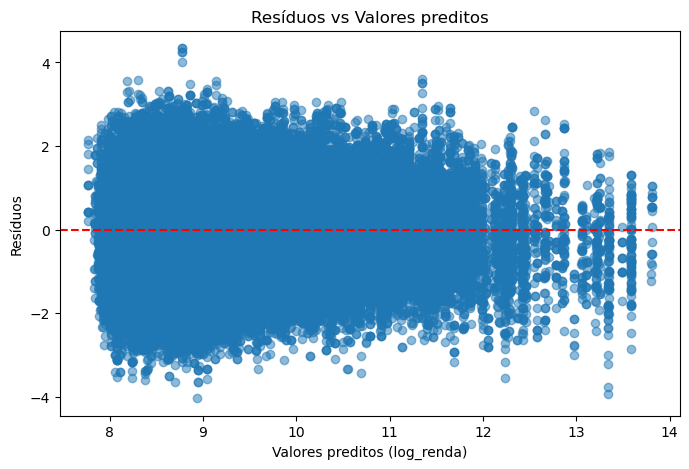

In [40]:
# Resíduos vs Preditos

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores preditos (log_renda)")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Valores preditos")
plt.show()

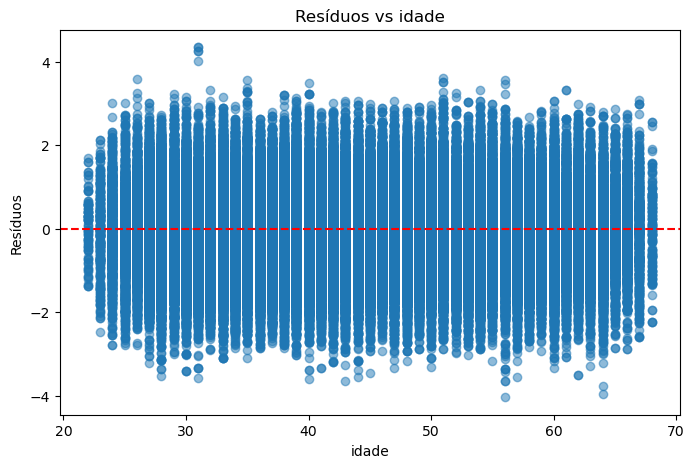

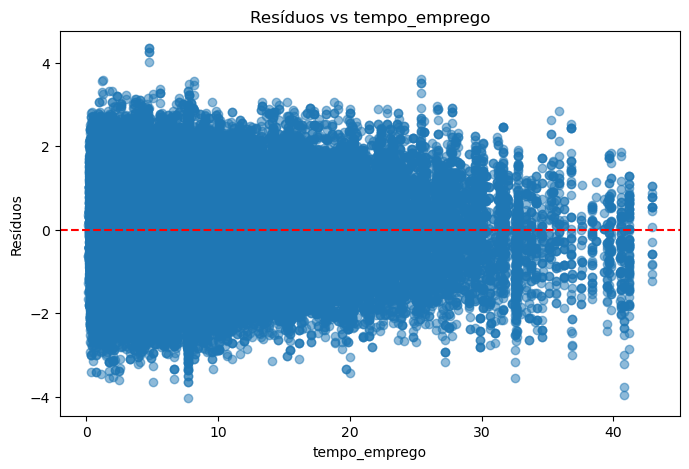

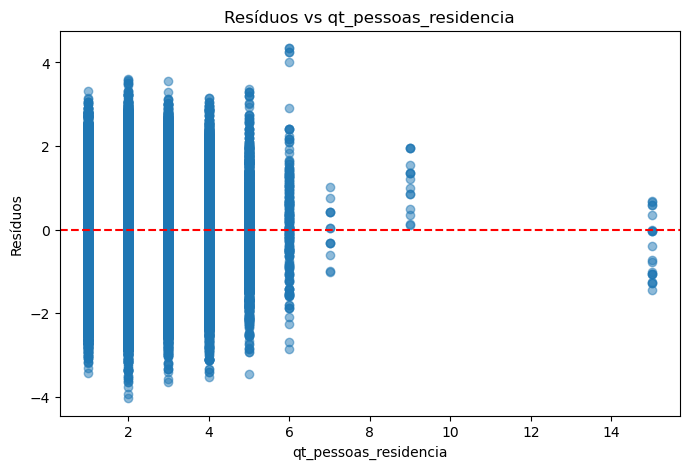

In [41]:
# Padrões dos resíduos vs variáveis explicativas

variaveis = ["idade", "tempo_emprego", "qt_pessoas_residencia"]

for var in variaveis:
    plt.figure(figsize=(8,5))
    plt.scatter(df_teste[var], residuos, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel(var)
    plt.ylabel("Resíduos")
    plt.title(f"Resíduos vs {var}")
    plt.show()

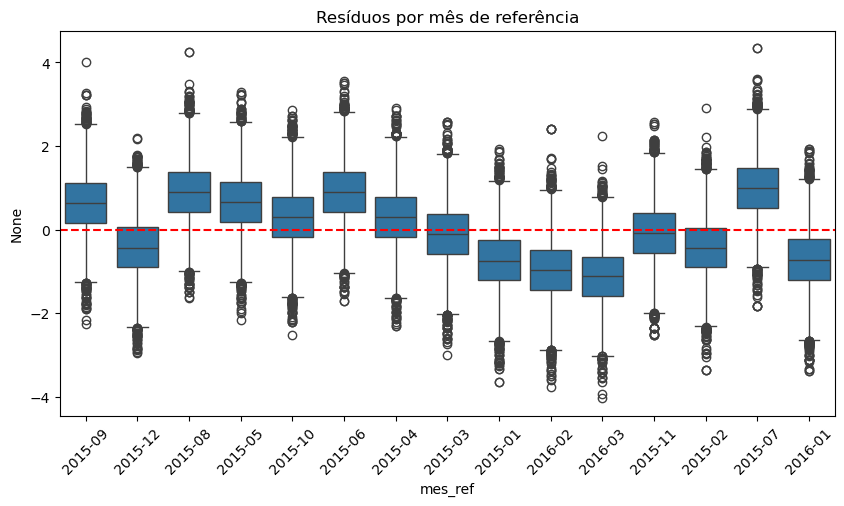

In [42]:
# Valor médio dos resíduos

if 'data_ref' in df.columns:
    df_teste['mes_ref'] = pd.to_datetime(df.loc[df_teste.index, 'data_ref']).dt.to_period("M")

    plt.figure(figsize=(10,5))
    sns.boxplot(x=df_teste['mes_ref'].astype(str), y=residuos)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Resíduos por mês de referência")
    plt.xticks(rotation=45)
    plt.show()

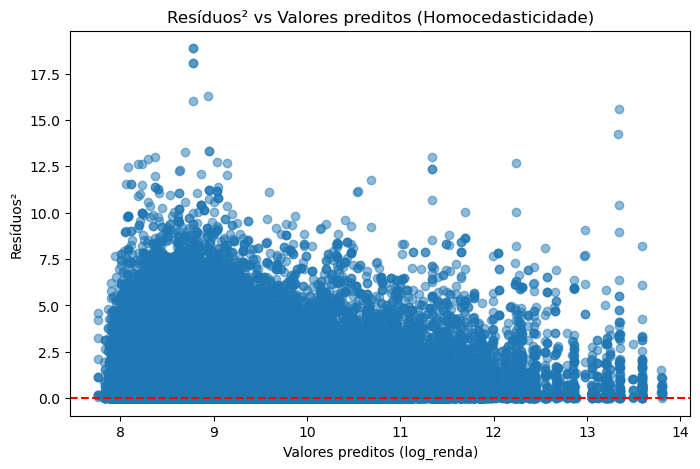

In [43]:
# Variância da variável resposta (Homocedasticidade)

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuos**2, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores preditos (log_renda)")
plt.ylabel("Resíduos²")
plt.title("Resíduos² vs Valores preditos (Homocedasticidade)")
plt.show()

### Análise das suposições do modelo

**Normalidade dos resíduos**: Os gráficos indicam que a distribuição dos resíduos é aproximadamente normal, com pequenas variações nas caudas (No QQ Plot <-3 e >3). No geral, a suposição de normalidade é razoavelmente atendida.

**Independência dos resíduos**: Nos gráficos de resíduos versus valores preditos e variáveis explicativas, não se observam padrões claros. Os resíduos estão bem espalhados em torno de zero, o que sugere independência.

**Resíduos vs Mês de referência**: A análise por mês mostra que a média dos resíduos se mantém próxima de zero ao longo do tempo, sem indicar tendência temporal clara, apesar de que em alguns meses a variação é sim um pouco mais acentuada, porém não demonstra um padrão claro, o que reforça a ideia de independência em relação ao tempo.

**Homoscedasticidade**: O gráfico de resíduos² versus valores preditos sugere uma leve redução da variância para rendas mais altas, indicando possível heterocedasticidade. O efeito, no entanto, parece moderado.

**Conclusão**: De forma geral, as suposições básicas do modelo estão atendidas em boa parte das análises. Há sinais leves de heterocedasticidade para rendas mais altas, que não comprometem a validade preditiva do modelo, mas que podem afetar a precisão de inferências estatísticas.


## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

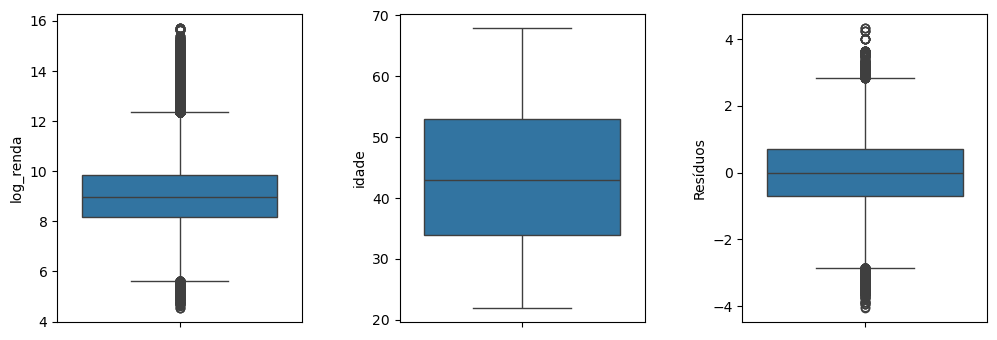

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
plt.subplots_adjust(wspace=0.4, hspace=0)

sns.boxplot(y=df_treino['log_renda'], ax=ax[0])
sns.boxplot(y=df_treino['idade'], ax=ax[1])
sns.boxplot(y=modelo.resid, ax=ax[2])  

ax[0].set_ylabel('log_renda')
ax[1].set_ylabel('idade')
ax[2].set_ylabel('Resíduos')
plt.show()

In [45]:
# Gráfico de influência com resíduos studentizados e leverage
# fig = sm.graphics.influence_plot(modelo, criterion="cooks")
# fig.tight_layout(pad=1.0)
# plt.show()

Não foi possível obter o resultado do gráfico de influência no modelo original.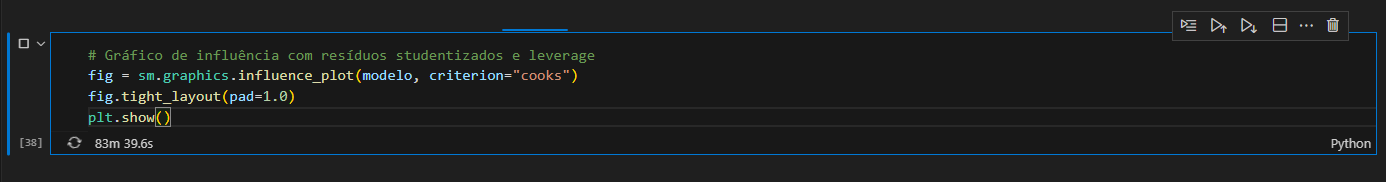

Como o modelo original possui muitas observações, o sistema estava demorando muito para conseguir calculcar tudo. Por isso, vamos tentar rodar o modelo em cima de uma amostra menor.

In [46]:
# Criando uma amostra de 10 mil observações
df_amostra = df_treino.sample(n=10000, random_state=42)
print(df_amostra.shape)

(10000, 13)


In [47]:
# Reajusta o mesmo modelo para a amostra
modelo_amostra = smf.ols(formula=formula, data=df_amostra).fit()
print(modelo_amostra.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     303.2
Date:                Sat, 30 Aug 2025   Prob (F-statistic):               0.00
Time:                        10:00:28   Log-Likelihood:                -14159.
No. Observations:               10000   AIC:                         2.837e+04
Df Residuals:                    9976   BIC:                         2.854e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

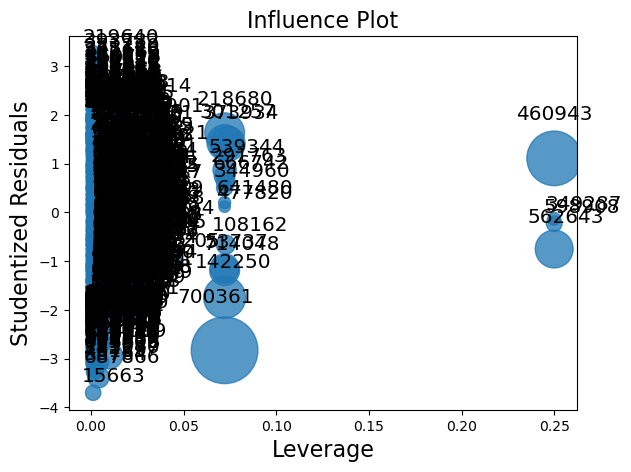

In [48]:
# Gráfico de influência usando apenas a amostra
fig = sm.graphics.influence_plot(modelo_amostra, criterion="cooks",fontsize=8)
fig.tight_layout(pad=1.0)
plt.show()

O influence_plot mostrou alguns pontos com alta alavancagem + resíduos studentizados grandes + Cook’s Distance relevante.

Esses pontos tendem a puxar os coeficientes e prejudicar tanto o ajuste quanto a generalização.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

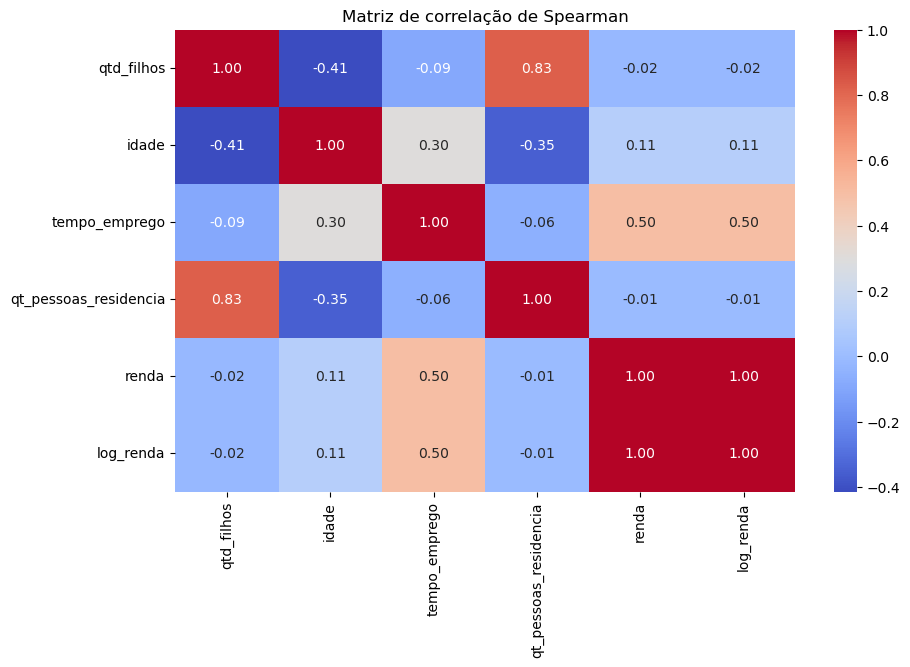

In [49]:
# Selecionar apenas variáveis numéricas do treino
num_vars = df_treino.select_dtypes(include=['float64','int64'])

# Calcular correlação de Spearman
corr_spearman = num_vars.corr(method='spearman')

# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlação de Spearman")
plt.show()

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Montar X apenas com variáveis numéricas que entram no modelo
X = df_treino.select_dtypes(include=['float64','int64'])
X = X.drop(columns=['renda', 'log_renda'], errors='ignore')

# Adicionar constante
X = sm.add_constant(X)

# Calcular VIF para cada variável
vif_data = pd.DataFrame()
vif_data["Variável"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                Variável        VIF
0                  const  40.060989
1             qtd_filhos   4.941076
2                  idade   1.232944
3          tempo_emprego   1.068359
4  qt_pessoas_residencia   4.825134


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [51]:
# Primeiro vamos limpar a base, removendo outliers globais

# Ajustar modelo para pegar resíduos no dataset inteiro
modelo_tmp = smf.ols(formula=formula, data=df).fit()
resid = modelo_tmp.resid
zresid = (resid - resid.mean()) / resid.std(ddof=1)

# Definir outliers globais
mask_out = zresid.abs() > 3
print(f"Removendo {mask_out.sum()} de {len(zresid)} observações do dataset inteiro.")

# Dataset limpo
df_limpo = df.loc[~mask_out].copy()


Removendo 868 de 750000 observações do dataset inteiro.


In [52]:
# Separando novamente entre treino e teste

df_limpo_treino, df_limpo_teste = train_test_split(df_limpo, test_size=0.2, random_state=42)


In [53]:
# Formula ajustada, sem a variável redundante `qt_pessoas_residencia` (alta correlação com `qtd_filhos`)
formula_ajustada = """
log_renda ~ idade + tempo_emprego + qtd_filhos
           + C(sexo) + C(posse_de_veiculo) + C(posse_de_imovel)
           + C(tipo_renda) + C(educacao) + C(estado_civil) + C(tipo_residencia)
"""

modelo_ajustado = smf.ols(formula=formula_ajustada, data=df_limpo_treino).fit()

In [54]:
# Comparação entre base original x base limpa

y_pred_base = modelo.predict(df_teste)
y_pred_aj   = modelo_ajustado.predict(df_limpo_teste)

r2_teste_base = r2_score(df_teste['log_renda'], y_pred_base)
r2_teste_aj   = r2_score(df_limpo_teste['log_renda'], y_pred_aj)

comparacao = pd.DataFrame({
    "Modelo": ["Base (com outliers)", "Ajustado (sem outliers, -qt_pessoas_residencia)"],
    "R² ajustado (treino)": [modelo.rsquared_adj, modelo_ajustado.rsquared_adj],
    "R² (teste)": [r2_teste_base, r2_teste_aj],
})

print(comparacao.to_string(index=False, float_format="%.4f"))


                                         Modelo  R² ajustado (treino)  R² (teste)
                            Base (com outliers)                0.3933      0.3930
Ajustado (sem outliers, -qt_pessoas_residencia)                0.3951      0.3994


### Conclusão
A comparação entre os modelos mostrou que os ajustes implementados trouxeram ganhos consistentes de desempenho. O modelo base, treinado com todos os dados e variáveis, apresentou R² ajustado de 0.3933 no treino e 0.3930 no teste.

Após a remoção de outliers (definidos por resíduos padronizados extremos) e da variável redundante `qt_pessoas_residencia` (altamente correlacionada com `qtd_filhos`) o modelo ajustado atingiu R² ajustado de 0.3951 no treino e 0.3994 no teste.

Dessa forma, vemos que a limpeza dos dados e a redução de multicolinearidade resultaram em um modelo mais estável, com leve melhora de explicação tanto na amostra de treinamento quanto na de teste, reforçando a importância do pré-processamento e da simplificação criteriosa das variáveis para obter maior capacidade preditiva.
